The Dixie Fire was a wildfire event which occurred in the Sierra Nevada mountain range in California in 2021. This fire burned 963,309 acres, or 1,505 square miles, which made it the largest single fire event in California history. The fire was also of particular note due to the fact that the blaze crossed from west to east over Sierra Crest, a milestone previously thought impossible for wildfires in California. This "impossible" feat was achieved again by the Caldor Fire later during the same fire season.

<img src="https://ca-times.brightspotcdn.com/dims4/default/ab84cb5/2147483647/strip/true/crop/3024x4032+0+0/resize/1200x1600!/format/webp/quality/75/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F3f%2F55%2F4e5281914311bbec8d6dc8aea6f4%2Fimage001-1.jpg">

> *Image source: https://ca-times.brightspotcdn.com/dims4/default/ab84cb5/2147483647/strip/true/crop/3024x4032+0+0/resize/1200x1600!/format/webp/quality/75/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F3f%2F55%2F4e5281914311bbec8d6dc8aea6f4%2Fimage001-1.jpg*

In [1]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Create the directory where we will download data for the project
data_path = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'dixie-fire')
os.makedirs(data_path, exist_ok=True)
data_path

'/home/jovyan/earth-analytics/data/dixie-fire'

In [3]:
# Download the Dixie Fire boundary spatial data and create a geodataframe

dixie_url = ('https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/'
             'services/InterAgencyFirePerimeterHistory_All_Years_View/'
             'FeatureServer/0/query?where=incident=%27DIXIE%27%20AND%20'
             'FIRE_YEAR_INT=2021%20AND%20SOURCE%20=%20%27CalFire%20FRAP'
             '%27&outFields=*&outSR=4326&f=json'
)

dixie_df = gpd.read_file(dixie_url)

# dixie_df

OBJECTID                MAP_METHOD      DATE_CUR  \
0     11634  Mixed Collection Methods  202107140015   

                                            COMMENTS GEO_ID  IRWINID  \
0  E9DB628D-DFB7-4C85-BCD6-1254574D946B, contains...  43182      NaN   

          UNQE_FIRE_ID FIRE_YEAR LOCAL_NUM INCIDENT  ... POO_RESP_I  \
0  2021-CABTU-00009205      2021  00009205    DIXIE  ...        NaN   

   FEATURE_CA GIS_ACRES USER_NAME        SOURCE AGENCY FIRE_YEAR_INT  \
0    Wildfire  963405.4       NaN  CalFire FRAP    CDF          2021   

    Shape__Area  Shape__Length  \
0  6.692866e+09   2.010262e+06   

                                            geometry  
0  MULTIPOLYGON (((-121.08903 40.32211, -121.0890...  

[1 rows x 21 columns]

In [4]:
# Create a map using Folium and the Camp Fire boundary data we downloaded
dixie_lat = 40.13775
dixie_lon = -121.06855

m = folium.Map(
    location=(dixie_lat, dixie_lon),
    zoom_start=10,
    scrollWheelZoom=False,
    tiles = ("https://server.arcgisonline.com/ArcGIS/rest/services/"
             "NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}"
            ),
    attr = ("Tiles &copy; Esri &mdash; National Geographic, Esri,"
            "DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN,"
            "GEBCO, NOAA, iPC'"
            )
    
    )

# Add polygon of Dixie Fire, add labels and marker for centroid of fire
for idx, row in dixie_df.iterrows():
    # Add polygon for Dixie Fire, add popup label
    
    poly_style = lambda feature: {"fillcolor": "#ffff00","color":"red"}
    poly = folium.GeoJson(row['geometry'],poly_style)
    label = folium.Popup(row['INCIDENT'])
    label.add_to(poly)
    poly.add_to(m)
    # create and add marker for centroid
    folium.Marker([dixie_lat, dixie_lon], popup="Dixie Fire").add_to(m)

m

## Data Overview
We are going to use data acquired from the MODIS sensor on the Aqua satellite platform. Aqua is an earth observing platform launched by Nasa in 2002.
It carries a number of earth observation sensors including MODIS (Moderate Resolution Imaging Spectroradiometer) which collects data over 36 spectral bands.

MODIS data can be used to visualize landcover using NDVI processing, which is a remote sensing method used to analyze reflectivity on Near Infrared and Red bands.
NDVI is useful in analyzing vegetation health.

## Citation: 
AppEEARS Team. (2023). Application for Extracting and Exploring Analysis Ready Samples (AppEEARS). Ver. 3.38. NASA EOSDIS Land Processes Distributed Active Archive Center (LP DAAC), USGS/Earth Resources Observation and Science (EROS) Center, Sioux Falls, South Dakota, USA. Accessed October 9, 2023. https://appeears.earthdatacloud.nasa.gov

In [5]:
# Delete files if I downloaded the wrong one

# del_data_path = data_path + "/modis-ndvi"

# for filename in os.listdir(del_data_path):
#     file_path = os.path.join(del_data_path, filename)
#     if os.path.isfile(file_path):
#         os.remove(file_path)

# if os.path.exists(del_data_path):
#     os.rmdir(del_data_path) 

In [6]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key='modis-ndvi',
    ea_dir=data_path,
    product='MYD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date='06-01',
    end_date='08-31',
    recurring=True,
    year_range=[2019, 2023],
    polygon=dixie_df
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()
ndvi_downloader



In [7]:
# Identify all directories within our main directory
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))
# ndvi_path_list

In [8]:
# Format the NDVI data into an array that we can plot
ndvi_da_list = []
doy_start = -19
doy_end = -12
scale_factor = 10000

for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor
    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)
# ndvi_da_list

# Stack the arrays
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])
# ndvi_ds

### Significant Imapacts to Vegetation Health

Analysis of NDVI data within the Dixie Fire boundary shows a significant reduction to vegetation health as a result of the fire.

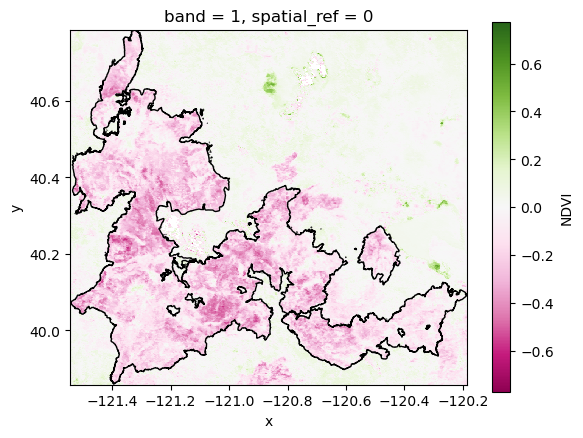

In [9]:
import matplotlib.pyplot as plt

# Get the data from 2019 and calculate the temporal mean
ndvi_ds_2019 = ndvi_ds.sel(date='2019')
ndvi_ds_2019_mean = ndvi_ds_2019.mean('date')

# Get the data from 2017 and calculate the temporal mean
ndvi_ds_2023 = ndvi_ds.sel(date='2023')
ndvi_ds_2023_mean = ndvi_ds_2023.mean('date')

# Calculate the difference between prefire and postfire years
ndvi_ds_difference = ndvi_ds_2023_mean - ndvi_ds_2019_mean

ndvi_ds_difference

# Plot the NDVI data and the Camp Fire boundary.
ndvi_plot = ndvi_ds_difference.NDVI.plot(cmap='PiYG')

ndvi_plot
dixie_df.plot(facecolor='none', ax=plt.gca())

plt.show()



### Vegetation Recovery Trend

NDVI analysis reveals that vegetation heatlh began to recover in 2022. Although there were likely high levels of tree mortality due to the fire, it is possible that some evergreen conifer and hardwood communities that did not experience complete kill were able to regenerate over this time period. Otherwise, it is likely that most of the vegetation regeneration indicated by NDVI were shrub and grassland communities.

In [10]:
# Create a geodataframe of area outside fire boundary
outside_env = gpd.GeoDataFrame(geometry=dixie_df.envelope)

out_gdf = outside_env.overlay(dixie_df, how="difference")

out_gdf

# Create GDFs of NDVI inside and outside fire
ndvi_in_dixie = ndvi_ds.rio.clip(dixie_df.geometry)
ndvi_out_dixie = ndvi_ds.rio.clip(out_gdf.geometry)

# Prepare the data for comparison
ndvi_fire_df = (ndvi_in_dixie
 .groupby(ndvi_in_dixie.date.dt.year)
 .mean(...)
 .NDVI
 .to_dataframe()[['NDVI']]
)

ndvi_out_df = (ndvi_out_dixie
 .groupby(ndvi_in_dixie.date.dt.year)
 .mean(...)
 .NDVI
 .to_dataframe()[['NDVI']]
)
# ndvi_fire_df, ndvi_out_df

import holoviews as hv

ndvi_diff_plot = (ndvi_fire_df - ndvi_out_df).hvplot(
    xlabel='Year', ylabel='dNDVI',
    title='Difference in NDVI values inside and outside Dixie Fire boundary'
)

# Plot vertical line for date of Camp Fire
ndvi_diff_plot * hv.VLine(2020).opts(color='red', line_width=6)

:Overlay
   .Curve.I :Curve   [year]   (NDVI)
   .VLine.I :VLine   [x,y]

In [13]:
%%bash
jupyter nbconvert DixeFire_NDVI.ipynb --to html --no-input

[NbConvertApp] WARNING | pattern 'DixeFire_NDVI.ipynb' matched no files


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

CalledProcessError: Command 'b'jupyter nbconvert DixeFire_NDVI.ipynb --to html --no-input\n'' returned non-zero exit status 255.